# Explore the Indo-Pacific Atolls Dataset (Comprehensive)

## Introduction
This notebook provides a comprehensive exploratory data analysis (EDA) of the "A multi-layer dataset of Indo-Pacific atolls" dataset. This dataset contains a rich collection of biogeographic, environmental, biodiversity, and human impact data for over 300 atolls across the Indo-Pacific basin, distributed across 21 files.

This notebook will guide you through loading all the datasets, integrating them into a master DataFrame, and visualizing the combined data to uncover key trends and insights.

### Install and import required libraries

In [ ]:
# Install mlcroissant from the source
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!pip install mlcroissant[dev]

In [29]:
import mlcroissant as mlc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from functools import reduce

from IPython.display import Markdown, display

## 1. Data Loading
First, we'll use the `mlcroissant` library to load all 21 record sets defined in the `fair2_croissant_ready.json` metadata file. The library reads the metadata and loads the corresponding data into pandas DataFrames.

In [30]:
# Load the dataset from the Croissant metadata file
ds = mlc.Dataset('fair2_croissant_ready.json')

# Load all record sets into a dictionary of pandas DataFrames
# The key is the record set name, and the value is the DataFrame
dataframes = {}
for rs in ds.metadata.record_sets:
    print(f"Loading record set: {rs.name}")
    records = ds.records(rs.id)
    df = pd.DataFrame(list(records))
    # FIX: mlcroissant creates columns with names like 'record_set/column'. We strip the prefix.
    df.columns = [col.split('/')[-1] for col in df.columns]
    dataframes[rs.name] = df

# Assign dataframes to the variables used in the original notebook.
main_df = dataframes['atoll_main_310_tidy']
biogeography_df = dataframes['atoll_biogeography_310_tidy']
environmental_df = dataframes['atoll_environmental_310_tidy']
oceanographic_df = dataframes['atoll_oceanographic_310_tidy']
landclass_df = dataframes['atoll_landclassification_310_tidy']
populations_df = dataframes['atoll_populations_310_tidy']
military_df = dataframes['atoll_military_use_tabelle1_tidy']
reefscape_df = dataframes['atoll_reefscape_310_tidy']
seabird_species_df = dataframes['atoll_seabird_population_by_species_tidy']
seabird_totals_df = dataframes['atoll_seabird_population_totals_tidy']
plants_df = dataframes['atoll_diversity_plants_sheet1_tidy']
birds_df = dataframes['atoll_diversity_birds_tidy']
reptiles_df = dataframes['atoll_diversity_reptiles_sheet1_tidy']
arthropods_df = dataframes['atoll_diversity_arthropods_sheet1_tidy']
landcrabs_df = dataframes['atoll_diversity_landcrabs_sheet1_tidy']
mammals_df = dataframes['atoll_diversity_native-mammals_sheet1_tidy']

# Load reference files (not used in the main merge but loaded for completeness)
plants_refs_df = dataframes['atoll_diversity_plants_refs_sheet1_tidy']
reptiles_refs_df = dataframes['atoll_diversity_reptiles_refs_sheet1_tidy']
arthropods_refs_df = dataframes['atoll_diversity_arthropods_refs_sheet1_tidy']
landcrabs_refs_df = dataframes['atoll_diversity_landcrabs_refs_sheet1_tidy']
mammals_refs_df = dataframes['atoll_diversity_native-mammals_refs_sheet1_tidy']

print("\nAll 21 record sets loaded successfully using mlcroissant.")

  -  [Metadata(Steibl_2025_indo_pacific_atoll_dataset)] Property "https://schema.org/datePublished" is recommended, but does not exist.


Loading record set: atoll_biogeography_310_tidy
Loading record set: atoll_diversity_reptiles_sheet1_tidy
Loading record set: atoll_diversity_birds_tidy
Loading record set: atoll_seabird_population_by_species_tidy
Loading record set: atoll_environmental_310_tidy
Loading record set: atoll_seabird_population_totals_tidy
Loading record set: atoll_diversity_plants_sheet1_tidy
Loading record set: atoll_landclassification_310_tidy
Loading record set: atoll_diversity_reptiles_refs_sheet1_tidy
Loading record set: atoll_military_use_tabelle1_tidy
Loading record set: atoll_main_310_tidy
Loading record set: atoll_oceanographic_310_tidy
Loading record set: atoll_populations_310_tidy
Loading record set: atoll_diversity_arthropods_refs_sheet1_tidy
Loading record set: atoll_diversity_landcrabs_refs_sheet1_tidy
Loading record set: atoll_diversity_landcrabs_sheet1_tidy
Loading record set: atoll_diversity_native-mammals_sheet1_tidy
Loading record set: atoll_diversity_arthropods_sheet1_tidy
Loading record

### 1.1 Dataset Metadata
Let's inspect the dataset's top-level metadata to understand its name and description.

In [31]:
# Get the dataset's metadata as a JSON-like dictionary
metadata = ds.metadata.to_json()

# Print the name and description
name = metadata.get('name', 'N/A')
# The description is under 'description' for Croissant < 1.0, and a list in > 1.0
description_obj = metadata.get('description', 'N/A')
if isinstance(description_obj, list):
    description = description_obj[0].get('@value', 'N/A')
else:
    description = description_obj
    
print(f"{name}: {description}")

Steibl_2025_indo_pacific_atoll_dataset: This dataset integrates multi-layer information on 310 atolls across the Indo-Pacific region, including geospatial attributes, environmental indicators, terrestrial and marine habitat classifications, species presence for plants, birds, reptiles, mammals, and arthropods, seabird population estimates, and human impact metrics such as population and military land use. Variables are consistently structured and annotated with source, method, and units, supporting robust analysis in island ecology, conservation, and climate research. The dataset is FAIR²-compliant and prepared for AI-ready applications through the MLCommons Croissant standard.


## 2. Data Preparation and Integration
To perform a holistic analysis, we will process and merge these datasets into a single, comprehensive DataFrame using the 'atoll' column as the common key.

In [32]:
# --- 1. Pre-process and summarize data --- #

# In some CSVs, there are invalid rows that are repetitions of the header.
# We will clean these by filtering out rows where the 'atoll' column has the value 'atoll'.
# We apply this to all biodiversity dataframes to be safe.
plants_df = plants_df[plants_df['atoll'] != 'atoll'].copy()
birds_df = birds_df[birds_df['atoll'] != 'atoll'].copy()
reptiles_df = reptiles_df[reptiles_df['atoll'] != 'atoll'].copy()
arthropods_df = arthropods_df[arthropods_df['atoll'] != 'atoll'].copy()
landcrabs_df = landcrabs_df[landcrabs_df['atoll'] != 'atoll'].copy()
mammals_df = mammals_df[mammals_df['atoll'] != 'atoll'].copy()

# This cleaning may cause some columns to be loaded as 'object' type. Let's fix presence columns.
for df in [birds_df, reptiles_df, arthropods_df, landcrabs_df, mammals_df]:
    if 'presence' in df.columns:
        df['presence'] = pd.to_numeric(df['presence'], errors='coerce')

# Pivot the reefscape data from long to wide format
reefscape_wide_df = reefscape_df.pivot(index='atoll', columns='metric', values='value').reset_index()

# Calculate species richness for each biodiversity group
plant_richness = plants_df.groupby('atoll')['species'].nunique().reset_index().rename(columns={'species': 'plant_richness'})
bird_richness = birds_df.groupby('atoll')['family_species'].nunique().reset_index().rename(columns={'family_species': 'bird_richness'})
reptile_richness = reptiles_df.groupby('atoll')['species'].nunique().reset_index().rename(columns={'species': 'reptile_richness'})
arthropod_richness = arthropods_df.groupby('atoll')['species'].nunique().reset_index().rename(columns={'species': 'arthropod_richness'})
landcrab_richness = landcrabs_df.groupby('atoll')['species'].nunique().reset_index().rename(columns={'species': 'landcrab_richness'})
mammal_richness = mammals_df.groupby('atoll')['species'].nunique().reset_index().rename(columns={'species': 'mammal_richness'})

# --- 2. Merge all dataframes --- #

# Some dataframes have a 'country' column, which would be duplicated from the main_df.
# We drop it from the other dataframes before merging.
if 'country' in populations_df.columns:
    populations_df = populations_df.drop(columns=['country'])
if 'country' in military_df.columns:
    military_df = military_df.drop(columns=['country'])
    
data_frames = [
    main_df.drop_duplicates(subset='atoll'),
    biogeography_df,
    environmental_df,
    oceanographic_df,
    landclass_df,
    populations_df,
    military_df,
    seabird_totals_df,
    reefscape_wide_df,
    plant_richness, bird_richness, reptile_richness, arthropod_richness, landcrab_richness, mammal_richness
]

# Use reduce to iteratively merge all dataframes on 'atoll'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='atoll', how='left'), data_frames)

display(Markdown("### Fully Integrated Atoll Data"))
display(merged_df.head())

### Fully Integrated Atoll Data

,atoll,region,country,group,lat,long,alternative_names,number_islands,land_area_sqkm,lagoon_area_sqkm,...,b'sheltered_reef_slope_perc',b'terrestrial_reef_flat_kmsq',b'terrestrial_reef_flat_perc',b'total_reef_extent_kmsq',plant_richness,bird_richness,reptile_richness,arthropod_richness,landcrab_richness,mammal_richness
0,b'Abaiang',b'Micronesia',b'Kiribati',b'Gilbert Islands',1.856900,172.947200,b'Apaiang',20.0,16.60,303.0,...,2.80,0.0,0.0,257.569,NaN,NaN,NaN,NaN,NaN,NaN
1,b'Abariringa',b'Polynesia',b'Kiribati',None,-2.816761,-171.674099,None,3.0,9.20,51.0,...,0.57,0.0,0.0,65.755,90.0,13.0,3.0,110.0,8.0,NaN
2,b'Abemama',b'Micronesia',b'Kiribati',b'Gilbert Islands',0.392700,173.865700,b'Apamama',5.0,27.40,200.0,...,2.35,0.0,0.0,169.138,NaN,5.0,NaN,NaN,NaN,NaN
3,b'Addu',b'Indian_Ocean',b'Maldives',None,-0.640090,73.157791,None,29.0,15.00,111.0,...,3.96,0.0,0.0,68.087,147.0,14.0,7.0,9.0,6.0,1.0
4,b'Agatti',b'Indian_Ocean',b'India',b'Lakshadweep',10.849093,72.178174,None,2.0,3.03,14.0,...,0.20,0.0,0.0,31.688,NaN,3.0,NaN,NaN,NaN,NaN


## 3. Exploratory Data Analysis (EDA)
Now, let's explore the fully integrated dataset.

### 3.1 Overview of the Integrated Dataset

In [33]:
print("Integrated Data Info:")
print(f"Shape of the merged dataframe: {merged_df.shape}")
merged_df.info(verbose=False, max_cols=0) # Get a concise summary

Integrated Data Info:
Shape of the merged dataframe: (317, 97)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Columns: 97 entries, atoll to mammal_richness
dtypes: float64(87), object(10)
memory usage: 240.4+ KB


### 3.2 Data Visualization

#### Global Distribution of Atolls

In [34]:
# Set the Mapbox token provided by the user
mapbox_token = "pk.eyJ1IjoiY3Jpc2JldGg0NiIsImEiOiJjbWM0dG1jeGMwa3Y0MmpzYTRobjM3NHp3In0.kGGMStYgqzcNE-i5u9wUMw"
px.set_mapbox_access_token(mapbox_token)

# FIX: The TypeError occurs because some string columns are loaded as bytes.
# We need to decode them to strings before plotting.
for col in ['atoll', 'region', 'country']:
    if col in merged_df.columns:
        # Apply a function to decode bytes to string, and leave other types as they are.
        merged_df[col] = merged_df[col].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Ensure numeric columns are properly typed for the plot, coercing errors
for col in ['lat', 'long', 'human_population', 'total_atoll_area_sqkm']:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Drop rows where lat/lon are missing, as they can't be plotted.
merged_df.dropna(subset=['lat', 'long'], inplace=True)
        
# Create the interactive map
fig = px.scatter_mapbox(
    merged_df,
    lat="lat",
    lon="long",
    hover_name="atoll",
    hover_data=["region", "country", "human_population"],
    color="region",
    size="total_atoll_area_sqkm",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=1,
    height=600,
    title="Global Distribution of Indo-Pacific Atolls"
)

fig.update_layout(mapbox_style="satellite-streets")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

/var/folders/sr/rb0fdyrd6mj5vn4v5zcgw8vm0000gp/T/ipykernel_10655/4096051376.py:21: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



#### Species-Area Relationship Across Different Taxa

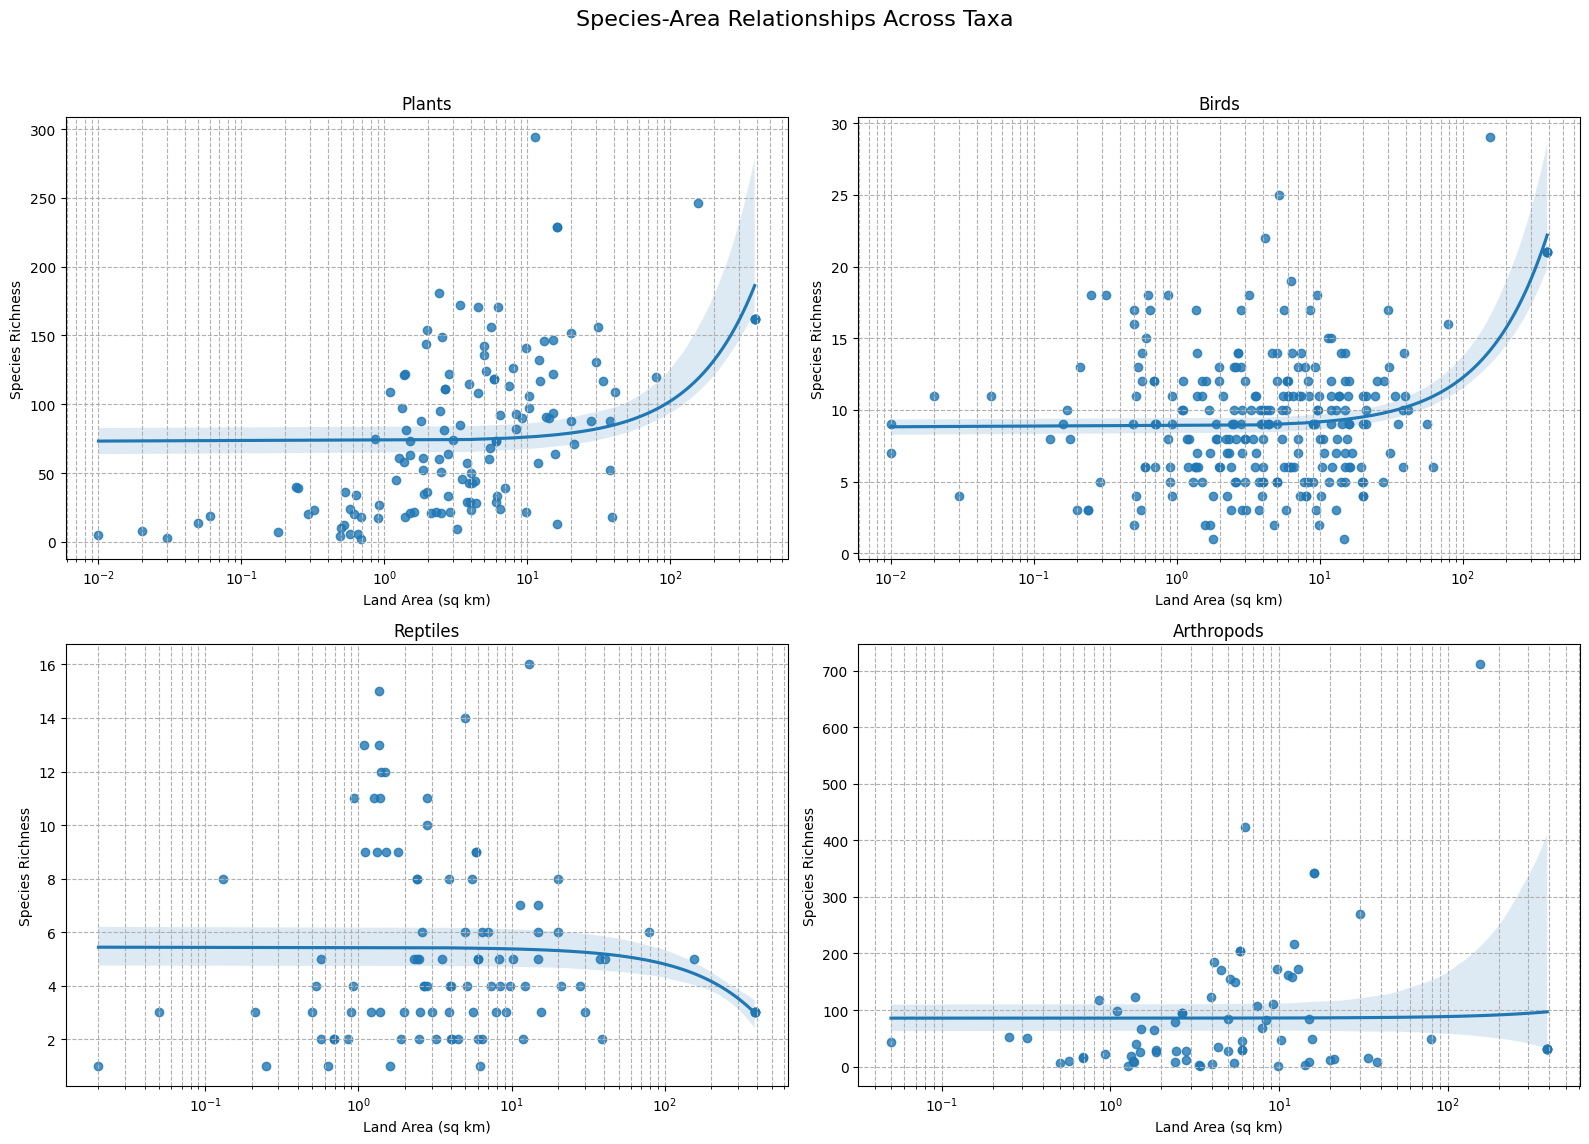

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Species-Area Relationships Across Taxa', fontsize=16)

sns.regplot(ax=axes[0, 0], data=merged_df, x='land_area_sqkm', y='plant_richness').set(xscale='log', title='Plants')
sns.regplot(ax=axes[0, 1], data=merged_df, x='land_area_sqkm', y='bird_richness').set(xscale='log', title='Birds')
sns.regplot(ax=axes[1, 0], data=merged_df, x='land_area_sqkm', y='reptile_richness').set(xscale='log', title='Reptiles')
sns.regplot(ax=axes[1, 1], data=merged_df, x='land_area_sqkm', y='arthropod_richness').set(xscale='log', title='Arthropods')

for ax in axes.flat:
    ax.set_xlabel('Land Area (sq km)')
    ax.set_ylabel('Species Richness')
    ax.grid(True, which="both", ls="--")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Correlation Matrix of Integrated Data

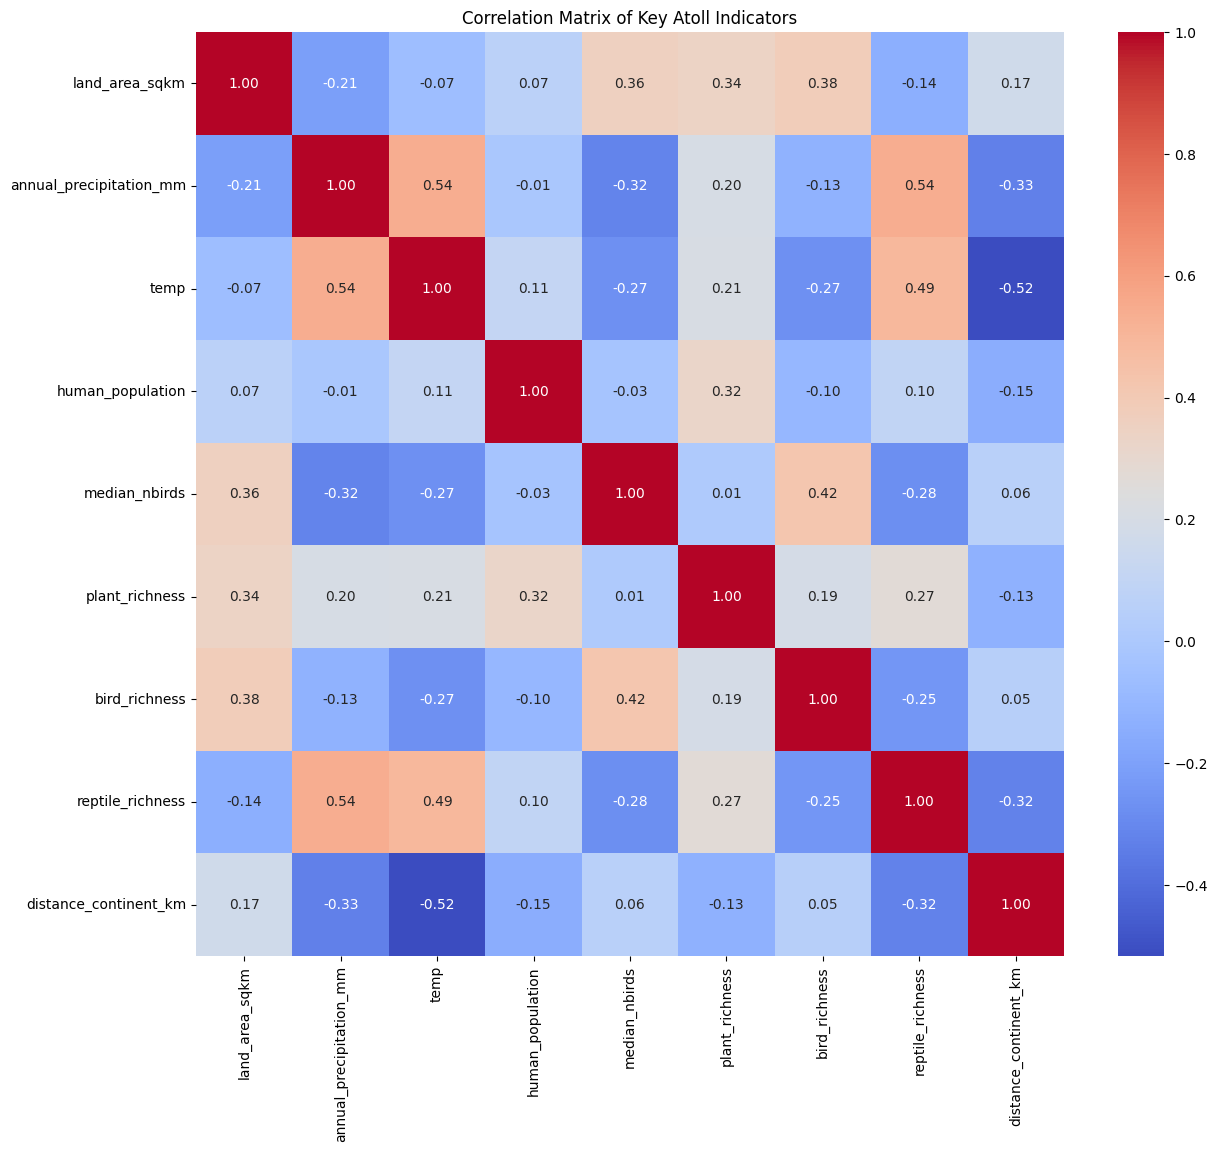

In [36]:
plt.figure(figsize=(14, 12))
corr_cols = ['land_area_sqkm', 'annual_precipitation_mm', 'temp', 'human_population', 'median_nbirds', 'plant_richness', 'bird_richness', 'reptile_richness', 'distance_continent_km']

# Ensure columns for correlation are numeric, coercing errors to NaN
for col in corr_cols:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
        
corr_matrix = merged_df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Atoll Indicators')
plt.show()

## 4. Conclusion
This notebook provided a comprehensive exploratory data analysis by integrating all 21 files of the Indo-Pacific Atolls dataset.

Our visualizations revealed:
- **Geographic Distribution**: We mapped the global distribution of the atolls, observing their concentration in distinct regions of the Indo-Pacific.
- **Species-Area Relationship**: A classic ecological pattern was consistently observed across multiple taxa, where atolls with larger land areas tend to support a higher number of species.
- **Correlations**: The correlation matrix highlighted several important relationships. Land area is positively correlated with species richness across all taxa and with seabird populations. Human population shows a negative correlation with seabird populations, suggesting potential impacts of human presence on wildlife. Distance from the continent also shows a negative correlation with plant and reptile richness, indicating the role of isolation in biodiversity.

This integrated analysis unlocks a deeper understanding of the complex interplay between physical, biological, and human factors across these unique atoll ecosystems, paving the way for more advanced modeling and conservation research.